# Construcción modelo Yahoo Finance

The "yahoo_finance_dataset(2018-2023)" dataset is a financial dataset containing daily stock market data for multiple assets such as equities, ETFs, and indexes. It spans from April 1, 2018 to March 31, 2023, and contains 1257 rows and 7 columns. The data was sourced from Yahoo Finance, and the purpose of the dataset is to provide researchers, analysts, and investors with a comprehensive dataset that they can use to analyze stock market trends, identify patterns, and develop investment strategies.
The dataset can be used for various tasks, including stock price prediction, trend analysis, portfolio optimization, and risk management. The dataset is provided in XLSX format, which makes it easy to import into various data analysis tools, including Python, R, and Excel.

The dataset includes the following columns:

Date: The date on which the stock market data was recorded.

Open: The opening price of the asset on the given date.

High: The highest price of the asset on the given date.

Low: The lowest price of the asset on the given date.

Close: The closing price of the asset on the given date. Note that this price does not take into account any after-hours trading that may have occurred after the market officially closed. Adj Close*: The adjusted closing price of the asset on the given date. This price takes into account any dividends, stock splits, or other corporate actions that may have occurred, which can affect the stock price.

Volume: The total number of shares of the asset that were traded on the given date.

### Importamos librerías

In [1]:
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Tratamiento de datos
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Feature selection
from sklearn.model_selection import train_test_split, StratifiedKFold
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Modelos ML
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier 
from prophet import Prophet


# Evaluación del modelo
import shap
from sklearn.metrics import roc_curve, roc_auc_score, auc

import streamlit as st

# Guardar modelo
import pickle

/home/arr/anaconda3/envs/timeseries/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/arr/anaconda3/envs/timeseries/lib/python3.11/site-packages/shap/utils/_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/arr/anaconda3/envs/timeseries/lib/python3.11/site-packages/shap/utils/_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, bu

In [196]:
#pip install streamlit

In [197]:
#pip install fbprophet

In [198]:
#pip install pystan numpy pandas

### Parámetros Notebook

In [199]:
n_jobs = 2

***

## Carga de datos

In [2]:
df_in = pd.read_excel('yahoo_data.xlsx')
df_in.shape

(1258, 7)

In [3]:
df_in.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Apr 28, 2023",33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,"Apr 27, 2023",33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,"Apr 26, 2023",33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,"Apr 25, 2023",33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,"Apr 24, 2023",33805.04,33891.15,33726.09,33875.40,33875.40,252020000


In [202]:
# Eliminamos la variable DEN_CNO
df_in.drop('Close*', axis=1, inplace=True)

In [203]:
# Renombrar la columna "Adj_Close**"
df_in = df_in.rename(columns={"Adj Close**": "Adj_Close"})

In [204]:
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Adj_Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 59.1+ KB


Ajustamos la muestra para construcción:

In [205]:
#Convertimos a formato fecha
df_in['Date'] = pd.to_datetime(df_in['Date'])
df_in.head()

,Date,Open,High,Low,Adj_Close,Volume
0,2023-04-28,33797.43,34104.56,33728.40,34098.16,354310000
1,2023-04-27,33381.66,33859.75,33374.65,33826.16,343240000
2,2023-04-26,33596.34,33645.83,33235.85,33301.87,321170000
3,2023-04-25,33828.34,33875.49,33525.39,33530.83,297880000
4,2023-04-24,33805.04,33891.15,33726.09,33875.40,252020000


In [206]:
#Vemos de que fecha a que fecha tenemos datos
fecha_minima = df_in['Date'].min()
fecha_maxima = df_in['Date'].max()

print('Fecha más cercana:', fecha_minima)
print('Fecha más lejana:', fecha_maxima)

Fecha más cercana: 2018-05-01 00:00:00
Fecha más lejana: 2023-04-28 00:00:00


In [207]:
#Ordenamos los valores por fecha
df_in = df_in.sort_values('Date')
df_in.head()

,Date,Open,High,Low,Adj_Close,Volume
1257,2018-05-01,24117.29,24117.29,23808.19,24099.05,380070000
1256,2018-05-02,24097.63,24185.52,23886.30,23924.98,385350000
1255,2018-05-03,23836.23,23996.15,23531.31,23930.15,389240000
1254,2018-05-04,23865.22,24333.35,23778.87,24262.51,329480000
1253,2018-05-07,24317.66,24479.45,24263.42,24357.32,307670000


In [208]:
#Dejamos un 15% de muestra Oot
#num_filas_val = int(len(df_in) * 0.15)
#num_filas_val

In [209]:
#df_val = df_in.head(num_filas_val)
#df_in = df_in.iloc[:-num_filas_val]
#print(f'df_val shape: {df_val.shape}')
#print(f'df_in shape: {df_in.shape}')

***

## Datos clave

#### Observamos los precios de Cierre a los largo del tiempo

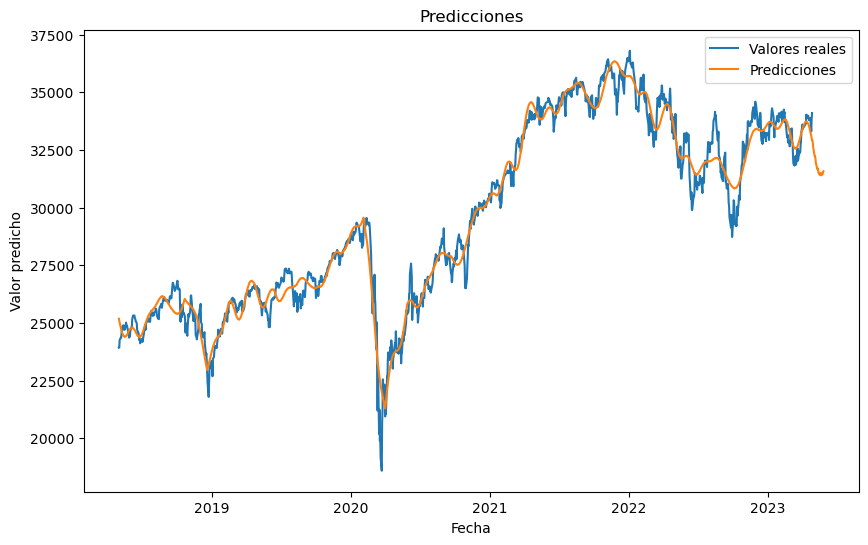

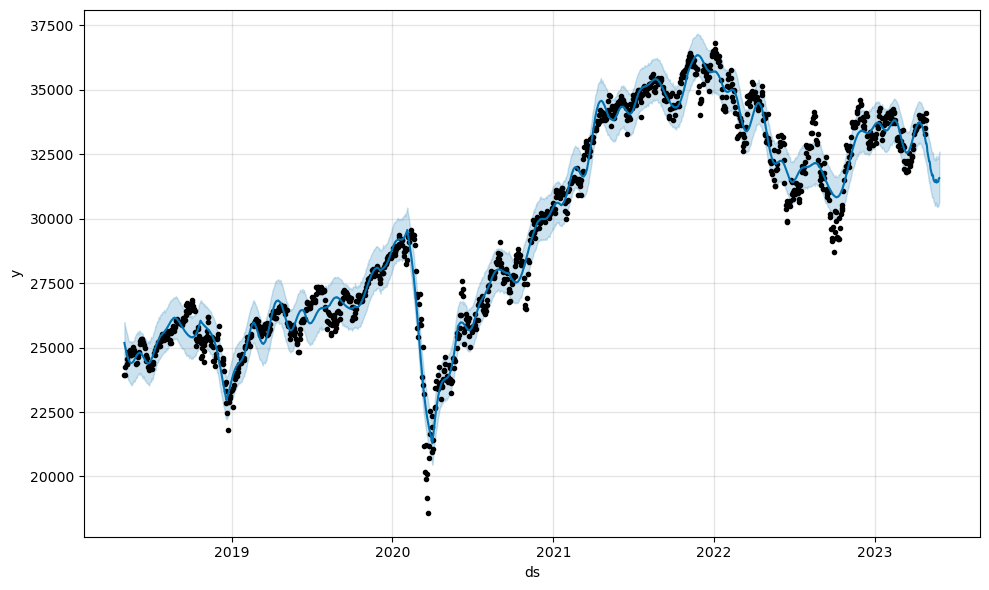

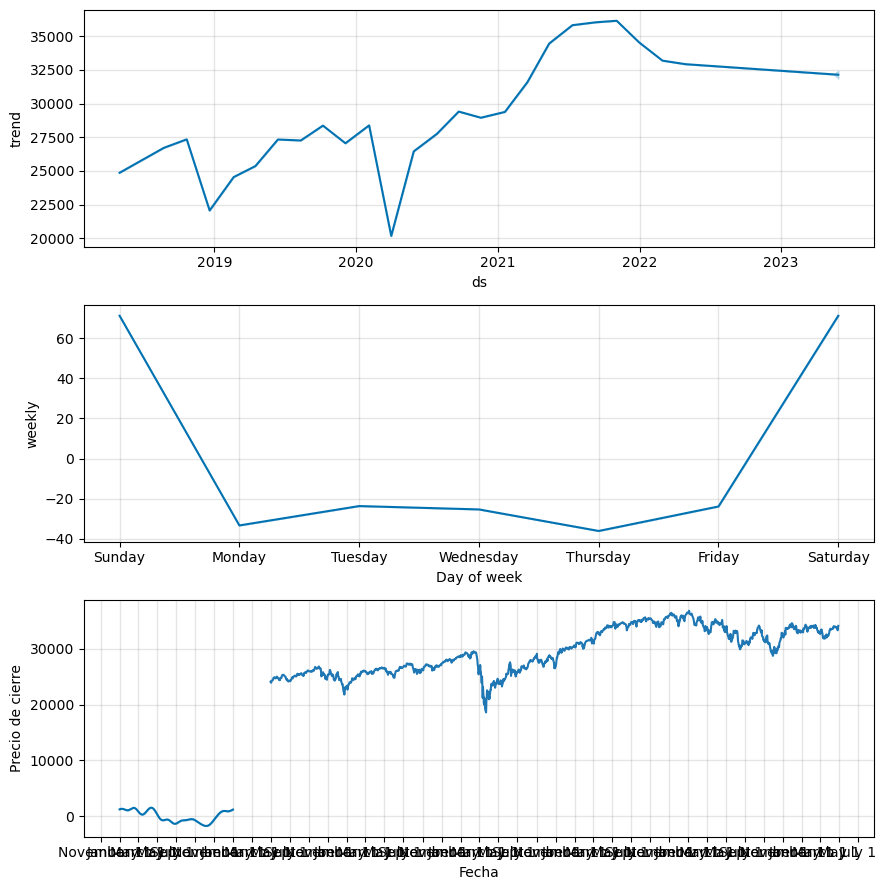

In [210]:
# Crear el gráfico de líneas
plt.plot(df_in['Date'], df_in['Adj_Close'])

# Establecer etiquetas de los ejes
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')

# Mostrar el gráfico
plt.show()

#### Calculamos la Diferencia del cambio diario en los precios de cierre

In [211]:
df_in['Dif_Cierre'] = df_in['Adj_Close'].diff()
df_in.head()

,Date,Open,High,Low,Adj_Close,Volume,Dif_Cierre
1257,2018-05-01,24117.29,24117.29,23808.19,24099.05,380070000,NaN
1256,2018-05-02,24097.63,24185.52,23886.30,23924.98,385350000,-174.07
1255,2018-05-03,23836.23,23996.15,23531.31,23930.15,389240000,5.17
1254,2018-05-04,23865.22,24333.35,23778.87,24262.51,329480000,332.36
1253,2018-05-07,24317.66,24479.45,24263.42,24357.32,307670000,94.81


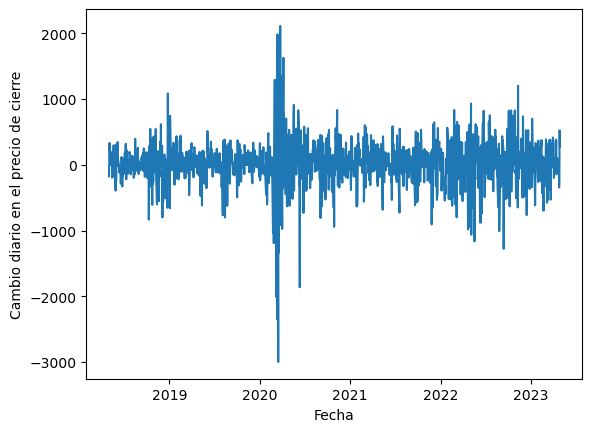

In [212]:
# Crear el gráfico de barras o línea
plt.plot(df_in['Date'], df_in['Dif_Cierre'])

# Establecer etiquetas de los ejes
plt.xlabel('Fecha')
plt.ylabel('Cambio diario en el precio de cierre')

# Mostrar el gráfico
plt.show()

#### Vemos la volatilidad diaria con la diferencia entre el precio máximo y el precio mínimo de cada día 

In [213]:
df_in['Dif_Max_Min'] = df_in['High'] - df_in['Low'] 
df_in.head()

,Date,Open,High,Low,Adj_Close,Volume,Dif_Cierre,Dif_Max_Min
1257,2018-05-01,24117.29,24117.29,23808.19,24099.05,380070000,NaN,309.10
1256,2018-05-02,24097.63,24185.52,23886.30,23924.98,385350000,-174.07,299.22
1255,2018-05-03,23836.23,23996.15,23531.31,23930.15,389240000,5.17,464.84
1254,2018-05-04,23865.22,24333.35,23778.87,24262.51,329480000,332.36,554.48
1253,2018-05-07,24317.66,24479.45,24263.42,24357.32,307670000,94.81,216.03


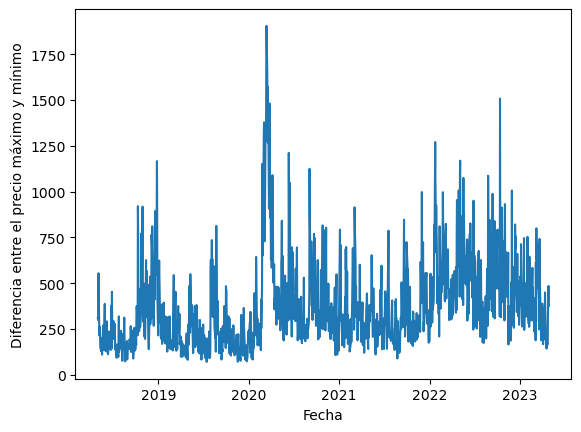

In [214]:
# Crear el gráfico de barras o línea
plt.plot(df_in['Date'], df_in['Dif_Max_Min'])

# Establecer etiquetas de los ejes
plt.xlabel('Fecha')
plt.ylabel('Diferencia entre el precio máximo y mínimo')

# Mostrar el gráfico
plt.show()

#### Volatilidad de los precios de cierre

Podemos observar una alta volatilidad en los precios de cierre a lo largo del tiempo

In [215]:
desv_Close = df_in['Adj_Close'].std()
print("Desviación estándar de los precios de cierre:", desv_Close)

Desviación estándar de los precios de cierre: 4007.4688215164624


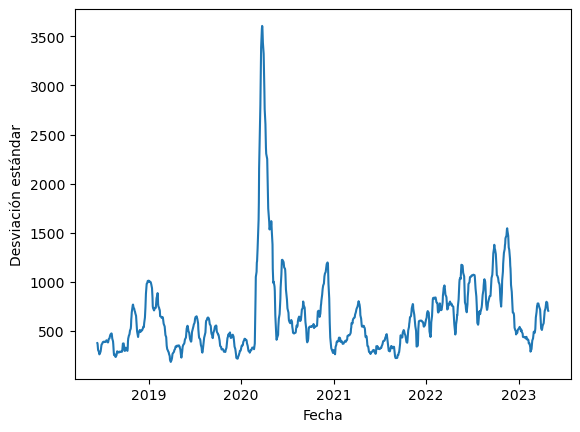

In [216]:
# Calcular la desviación estándar en cada punto de tiempo
desv_cierre_fecha = df_in['Adj_Close'].rolling(window=30).std()

# Crear el gráfico de línea
plt.plot(df_in['Date'], desv_cierre_fecha)

# Establecer etiquetas de los ejes
plt.xlabel('Fecha')
plt.ylabel('Desviación estándar')

# Mostrar el gráfico
plt.show()

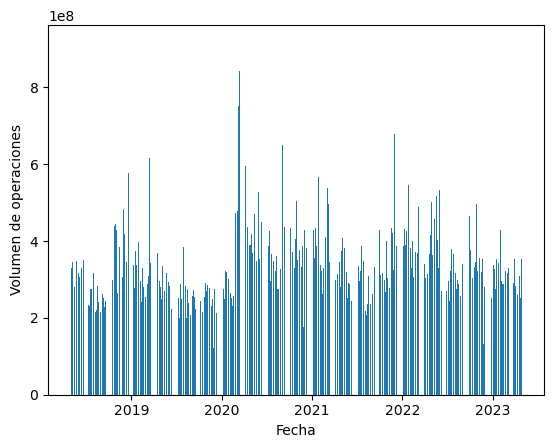

In [217]:
plt.bar(df_in['Date'], df_in['Volume'])
plt.xlabel('Fecha')
plt.ylabel('Volumen de operaciones')
plt.show()

#### Identificamos divergencias entre los cambios de precios y el volumen de operaciones

In [218]:
# Identificar días de subida de precios con disminución del volumen
df_in['Subida'] = ((df_in['Dif_Cierre'] > 0) & (df_in['Volume'].shift(1) > df_in['Volume'])).astype(int)

# Identificar días de baja de precios con aumento del volumen
df_in['Bajada']  = ((df_in['Dif_Cierre'] < 0) & (df_in['Volume'].shift(1) < df_in['Volume'])).astype(int)

print("Días de subida con disminución del volumen:")
df_in.head()

Días de subida con disminución del volumen:


,Date,Open,High,Low,Adj_Close,Volume,Dif_Cierre,Dif_Max_Min,Subida,Bajada
1257,2018-05-01,24117.29,24117.29,23808.19,24099.05,380070000,NaN,309.10,0,0
1256,2018-05-02,24097.63,24185.52,23886.30,23924.98,385350000,-174.07,299.22,0,1
1255,2018-05-03,23836.23,23996.15,23531.31,23930.15,389240000,5.17,464.84,0,0
1254,2018-05-04,23865.22,24333.35,23778.87,24262.51,329480000,332.36,554.48,1,0
1253,2018-05-07,24317.66,24479.45,24263.42,24357.32,307670000,94.81,216.03,1,0


***

## Preproceso de datos

Ahora separamos los dataset en dataset de entrenamiento y de out-of-time

Selección de modelos adecuados: Consideramos aquellos que sean más resistentes a la volatilidad y capaces de capturar 
patrones cambiantes en los datos. Algunos modelos robustos para datos volátiles incluyen modelos de series temporales,
modelos basados en árboles (como Random Forest o XGBoost) o modelos de aprendizaje profundo que pueden capturar 
relaciones no lineales complejas.

Validación del modelo: validación cruzada o la validación en un período de tiempo fuera del conjunto de entrenamiento para evaluar la capacidad de tu modelo para manejar la volatilidad.

In [219]:
for index, num in zip(df_in.isna().sum().index, df_in.isna().sum().values):
    if num > 0:
        print(index, num)

Dif_Cierre 1


Al tener tan pocos registros con valores nulos, optamos por eliminarlos

In [220]:
df_in.dropna(axis=0, inplace=True)
print(df_in.shape)

(1257, 10)


### Ejecutamos el modelo

El modelo Prophet utiliza un enfoque aditivo para modelar las series de tiempo, y divide automáticamente los datos en una parte de entrenamiento y una parte de prueba durante el ajuste del modelo. Internamente, utiliza un período de tiempo para el entrenamiento y posteriormente realiza las predicciones para los períodos futuros.

Cuando utilices model.fit(data)en Prophet, el modelo ajustará automáticamente los datos hasta una fecha específica, dejando los datos posteriores sin ajustar. Luego, puedes generar fechas futuras con model.make_future_dataframe()y utilizarlas para obtener las predicciones correspondientes.

Prophet tiene una función incorporada llamada "cross-validation" que se encarga de evaluar la calidad del modelo utilizando el período de prueba. Esta función realiza la validación cruzada internamente y calcula las métricas de evaluación para ti.

In [221]:
#Preparamos los datos en el formato reqerido por Prophet
data = df_in[['Date', 'Adj_Close']]
data = data.rename(columns={'Date': 'ds', 'Adj_Close': 'y'})

In [280]:
#Creamos una instancia del modelo Prophet y ajustamos los datos
model = Prophet(changepoint_prior_scale=0.7, seasonality_prior_scale=0.1, interval_width=0.99)
model.fit(data)

13:06:47 - cmdstanpy - INFO - Chain [1] start processing


13:06:48 - cmdstanpy - INFO - Chain [1] done processing


In [281]:
#Generamos fechas futuras para hacer las predicciones
future_dates = model.make_future_dataframe(periods=30)  # Aquí puedes ajustar la cantidad de días futuros que deseas predecir

El resultado lo guardamos en el DataFrame forecast, que contiene columnas como 'ds', 'yhat', 'yhat_lower' y 'yhat_upper'. La columna 'yhat' representa las predicciones para 'adj_close', mientras que 'yhat_lower' y 'yhat_upper' son los límites inferiores y superiores del intervalo de confianza.

In [282]:
#Hacemos las predicciones
forecast = model.predict(future_dates)

In [283]:
#Accedemos a las predicciones de 'Adj_Close' y las fechas correspondientes
predicted_adj_close = forecast[['ds', 'yhat']]

### Evaluamos el modelo

Error cuadrático medio (MSE, por sus siglas en inglés): El MSE mide el promedio de los errores al cuadrado entre las predicciones y los valores reales. Un MSE más bajo indica un mejor ajuste del modelo.

In [284]:
from sklearn.metrics import mean_squared_error

actual_values = df_in['Adj_Close'].values[-len(forecast):]  # Valores reales correspondientes a las predicciones
predicted_values = forecast['yhat'].values

mse = mean_squared_error(actual_values, predicted_values[:len(actual_values)])
print(mse)

395104.8239839206


Error absoluto medio (MAE, por sus siglas en inglés): El MAE mide el promedio de los errores absolutos entre las predicciones y los valores reales. Al igual que el MSE, un MAE más bajo indica un mejor ajuste del modelo

In [285]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(actual_values, predicted_values[:len(actual_values)])
print(mae)

466.92680777479404


R cuadrado (R²): El R² indica la proporción de la varianza en los datos de respuesta que se puede predecir a partir de las variables independientes. Un valor de R² más cercano a 1 indica un mejor ajuste del modelo

In [286]:
from sklearn.metrics import r2_score

r2 = r2_score(actual_values, predicted_values[:len(actual_values)])
print(r2)

0.9753609540101111


Visualizamos los resultados del modelo utilizando gráficos para comparar las predicciones con los valores reales. Trazamos un gráfico de línea que muestre los valores reales y las predicciones a lo largo del tiempo.

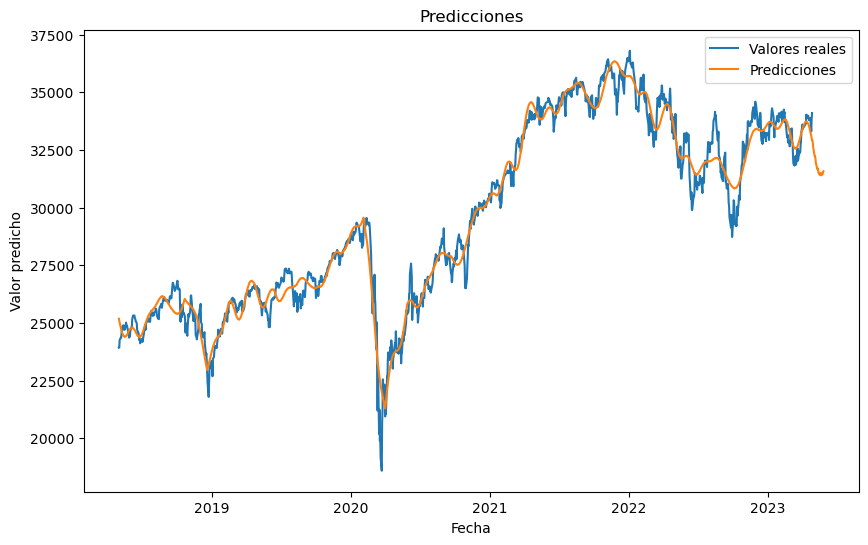

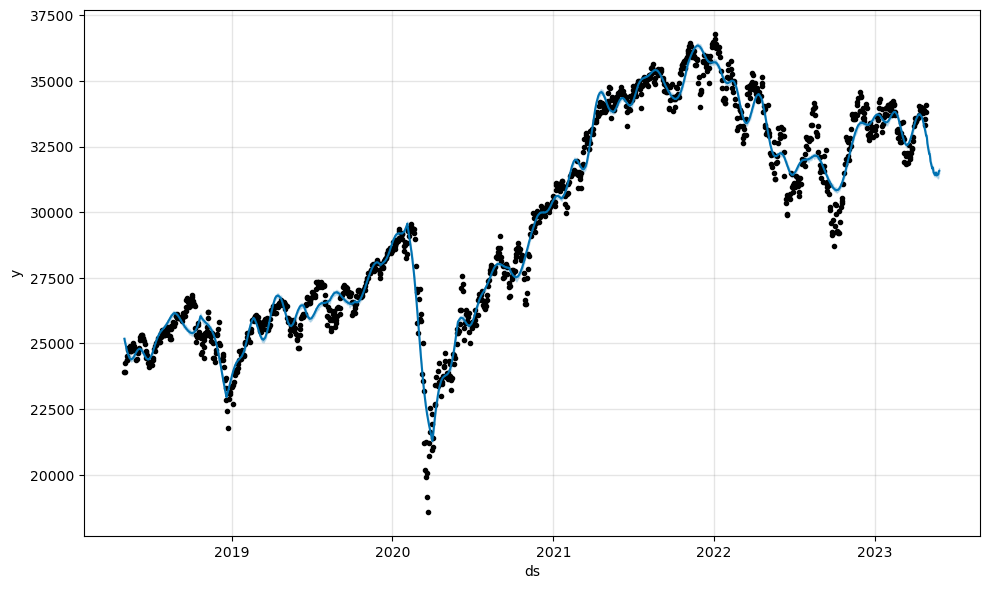

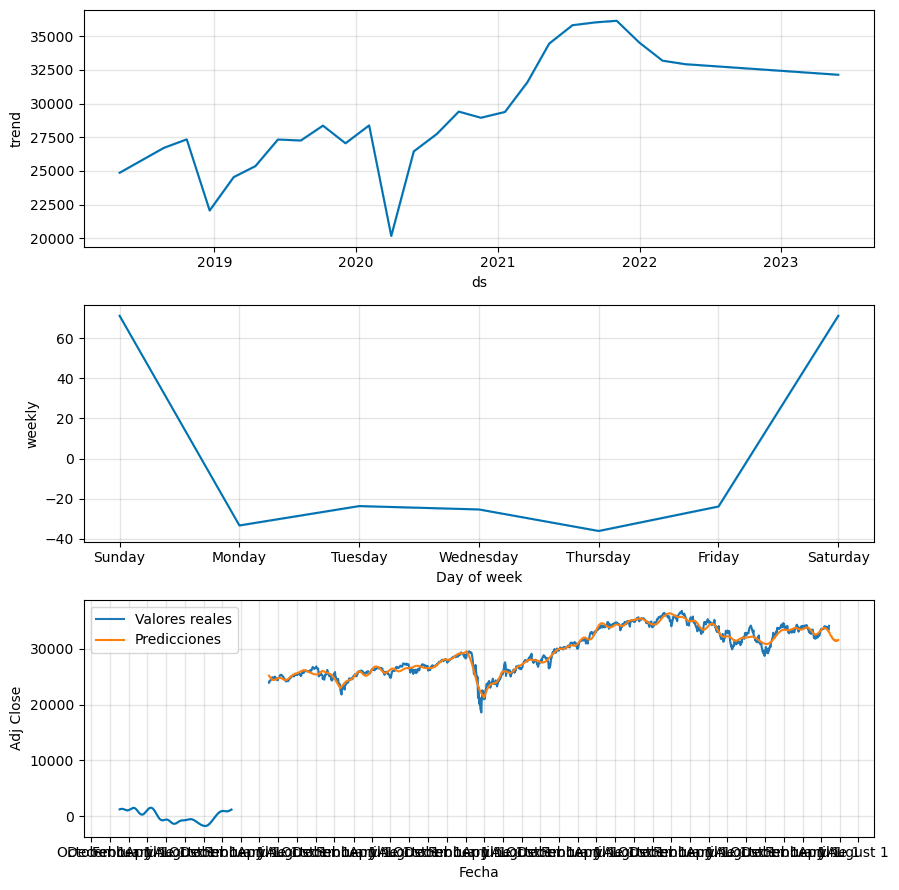

In [287]:
import matplotlib.pyplot as plt

plt.plot(df_in['Date'], df_in['Adj_Close'], label='Valores reales')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

In [288]:
# Configura la aplicación Streamlit
st.title('Gráfico de Predicciones')

DeltaGenerator()

In [289]:
# Crea el gráfico con las predicciones
plt.figure(figsize=(10, 6))
plt.plot(df_in['Date'], df_in['Adj_Close'], label='Valores reales')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Valor predicho')
plt.title('Predicciones')
plt.legend()

# Muestra el gráfico en Streamlit
st.pyplot(plt)

DeltaGenerator()

In [290]:
# from fbprophet import Prophet

# # Crear el DataFrame para el modelo Prophet
# df_prophet = df_in[['Date', 'Adj_Close']].copy()
# df_prophet.columns = ['ds', 'y']

# # Crear y entrenar el modelo Prophet
# model = Prophet()
# model.fit(df_prophet)

# # Generar las fechas futuras para hacer las predicciones
# future = model.make_future_dataframe(periods=365)  # Se generan 365 días futuros

# # Realizar las predicciones
# forecast = model.predict(future)

# # Visualizar las predicciones
# model.plot(forecast)

In [291]:
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objects as go

In [292]:
plot_plotly(model, forecast)

In [293]:
fig1 = model.plot(forecast)

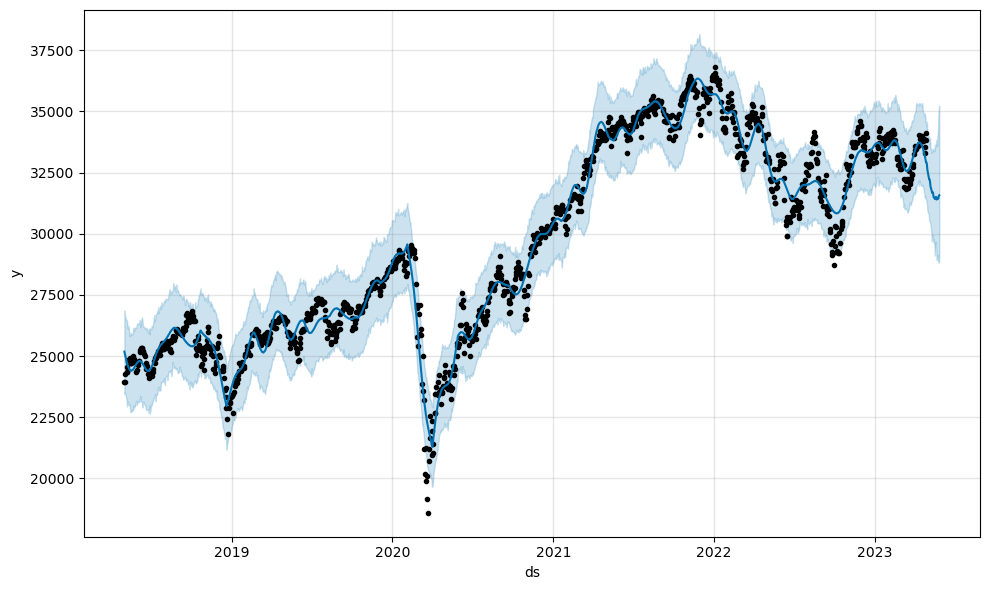

In [294]:
fig1

In [295]:
fig2 = model.plot_components(forecast)

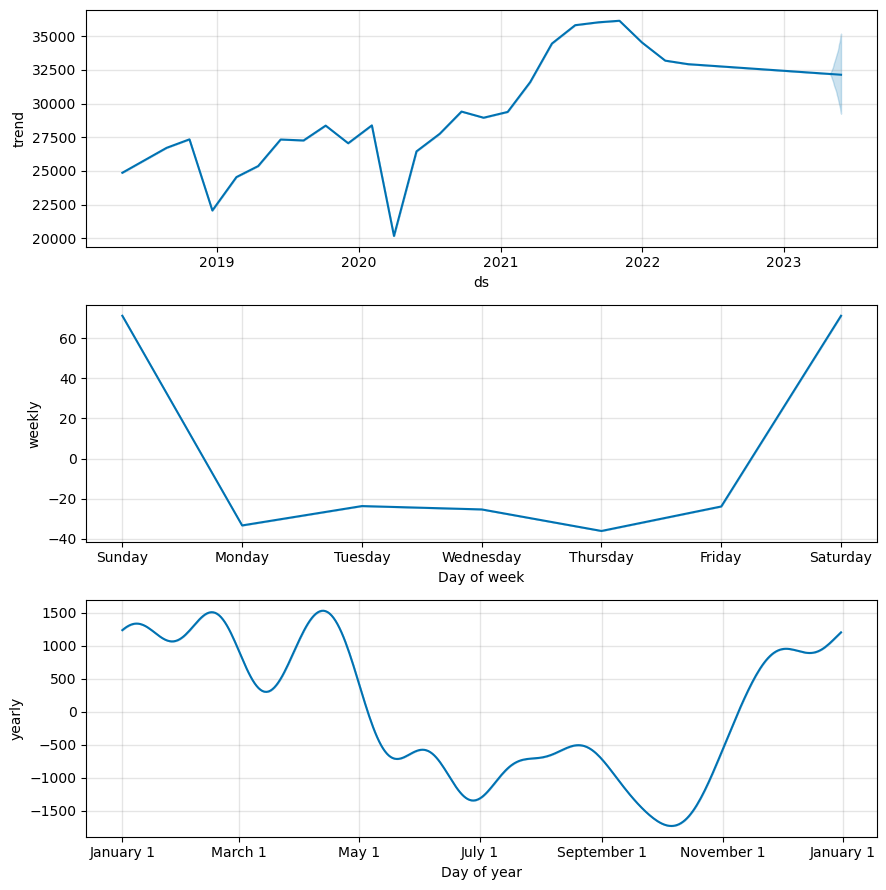

In [296]:
fig2

In [297]:
plot_components_plotly(model, forecast)

In [298]:
print("ejecución terminada")

ejecución terminada
